In [91]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from utils_hyperelasticity import NODE_old as NODE, NODE_nobias, sigma_split as sigma_NODE, sigma_split_vmap
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)

from scipy.integrate import odeint
import pandas as pd

In [78]:
# Various useful functions
# 2 different functions to initialize 2 different NN architectures
def init_params_positivebias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b
def init_params_nobias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]
dPhi_gov_vmap = vmap(dPhi_gov, in_axes=(0, None, None), out_axes=(0))

# Neural ODE based dPhi/dtaui
def dPhi_NODE(taui, Phi_params):
    # NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params
    NODE3_params, NODE4_params, NODE5_params = Phi_params
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = N2 = 0
    N3 = N3*out_std3
    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return [Phi1, Phi2, Phi3]
dPhi_vmap = vmap(dPhi_NODE, in_axes=(0, None), out_axes = (0))

def tau_Ogden(lm1e, lm2e, lm3e, Psi_neq_params):
    alpha_m, mu_m, K_m = Psi_neq_params
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*(K_m*10000)/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    return tau_A

def tau_NEQ_NODE(lm1, lm2, lm3, Psi_neq_params):
    J = lm1*lm2*lm3
    sigma_NEQ = sigma_NODE(lm1, lm2, lm3, Psi_neq_params)
    tau_NEQ = J*sigma_NEQ
    return tau_NEQ

def sigma_Ogden(lm1e, lm2e, lm3e, Psi_neq_params):
    tau_A = tau_Ogden(lm1e, lm2e, lm3e, Psi_neq_params)
    Je = lm1e*lm2e*lm3e
    tau = np.array([[tau_A[0], 0, 0],
                    [0, tau_A[1], 0],
                    [0, 0, tau_A[2]]]) #Since stress and strain are coaxial in the isotropic case

    sigma = 1/Je*tau
    return sigma
sigma_Ogden_vmap = vmap(sigma_Ogden, in_axes=(0,0,0,None), out_axes=0)

def sigma_neoHook(lm1, lm2, lm3, Psi_eq_params): #Neo hookean
    K, mu = Psi_eq_params
    J = lm1*lm2*lm3
    b = np.array([[lm1**2, 0, 0],
                [0, lm2**2, 0],
                [0, 0, lm3**2]])
    # sigma = mu/J*(b-np.eye(3)) + (K*10000)*(J**2-1)/2/J*np.eye(3) #From Wiki
    trb = b[0,0] + b[1,1] + b[2,2] 
    sigma = mu/J**(5/3)*(b-1/3*trb*np.eye(3)) + (K*10000)*(J**2-1)/2/J*np.eye(3) #Adapted from Treloar, Proc Phys Soc 60 135-44 1948
    return sigma
sigma_neoHook_vmap = vmap(sigma_neoHook, in_axes=(0,0,0,None), out_axes=0)

def sigma(inputs, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    if useNODE: # use NODE
        Psi_eq_params, Psi_neq_params, Phi_params = params
        sigma_EQ  = sigma_NODE(lm1, lm2, lm3, Psi_eq_params)
        sigma_NEQ = sigma_NODE(lm1e, lm2e, lm3e, Psi_neq_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        sigma_NEQ = sigma_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params)
        sigma_EQ = sigma_neoHook(lm1, lm2, lm3, gov_Psi_eq_params)
        # sigma_EQ = sigma_Ogden(lm1, lm2, lm3, gov_Psi_eq_params)
        
    sigma = sigma_NEQ + sigma_EQ
    return sigma
getsigma = vmap(sigma, in_axes=(0, None, None), out_axes=0)
dsigma33 = grad(lambda inputs, params, useNODE: sigma(inputs,params,useNODE)[2,2])


def yprime_biaxial(y, t, lm1dot, lm2dot, tpeak, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t)

    if useNODE: # use NODE 
        Psi_eq_params, Psi_neq_params, Phi_params = params
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        eta_D, eta_V = gov_Phi_params
        tau_A = tau_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params) 
        dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = (lm2dot/lm2 - 0.5*dphidtaui[1])*lm2e

    d = dsigma33([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    A = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lm1edot + d[4]*lm2edot)/d[2]
    B = -d[5]/d[2]

    Apr = A/lm3
    Bpr = B/lm3

    lm3edot = (Apr - 0.5*dphidtaui[2])/(1-Bpr*lm3e)*lm3e
    lm3dot = A + B*lm3edot
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

def yprime_triaxial(y, t, lm1dot, tpeak, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array(lm1dot)
    false_fun = lambda t: np.array(   0.0)
    lm1dot = cond(t<tpeak, true_fun, false_fun, t)

    if useNODE: # use NODE 
        Psi_eq_params, Psi_neq_params, Phi_params = params
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        eta_D, eta_V = gov_Phi_params
        tau_A = tau_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params) 
        dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = np.array(-0.5*dphidtaui[1]*lm2e)
    lm3edot = np.array(-0.5*dphidtaui[2]*lm3e)

    lm2dot = lm3dot = np.array(0)

    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

# @partial(jit, static_argnums=(1,))
def biaxial_visco(params, useNODE, time, lm1, lm2):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak
    
    # Diffrax integrator
    # yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE))
    # term = ODETerm(yprime)
    # solver = mysolver()
    # y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    # saveat = SaveAt(ts=time)
    # solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=0.5, y0=y0, saveat=saveat)
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    # Scipy integrator
    yprime = lambda y, t: yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE)
    y0 = [1.0,1.0,1.0,1.0,1.0,1.0]
    lm1, lm2, lm3, lm1e, lm2e, lm3e = odeint(yprime, y0, time).transpose()

    # Manual forward Euler
    # n = 999
    # dt = time[-1]/n
    # time = np.linspace(0, time[-1], n)
    # y = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    # y_hist = [y]
    # for i in range(n):
    #     t = time[i]
    #     dy = np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE))
    #     y_new = y + dy*dt
    #     y_hist.append(y_new)
    #     y = y_new
    #     pass
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = np.array(y_hist).transpose()
    

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

@partial(jit, static_argnums=(1,))
def triaxial_visco(params, useNODE, time, lamb):
    ipeak = np.argmax(np.abs(np.around(lamb, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    tpeak = time[ipeak]
    lambpeak = lamb[ipeak]

    lambdot = (lambpeak-1.0)/tpeak

    yprime = lambda t, y, args: np.array(yprime_triaxial(y,t,lambdot,tpeak,params,useNODE))
    term = ODETerm(yprime)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=0.5, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

def moving_average(a, n=10):
    ret = onp.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot45(gts, prs, labels, title, constrained=True):
    nplots = len(gts)
    fig, ax = plt.subplots(1,nplots, figsize=(nplots*5,4))

    for i in range(nplots):
        xmin,xmax = np.min(gts[i]), np.max(gts[i])
        ax[i].plot([xmin,xmax], [xmin, xmax], 'r-')
        ax[i].plot(gts[i],prs[i], '.')
        ax[i].set(xlabel='Ground truth ' + labels[i],
                  ylabel='Predicted ' + labels[i])
        if constrained:
            ax[i].set(xlim = [xmin, xmax], ylim = [xmin, xmax])
    fig.suptitle(title)
    fig.subplots_adjust(wspace=0.4)

In [4]:
#Load the pre-trained parameters
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Phi_norm_w.npy', 'rb') as f:
    [inp_stds, out_stds] = pickle.load(f)
[inp_std1, inp_std2, inp_std3, inp_std4, inp_std5] = inp_stds
[out_std1, out_std2, out_std3, out_std4, out_std5] = out_stds
params = (Psi_eq_params, Psi_neq_params, Phi_params)

with open('saved/gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)

with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

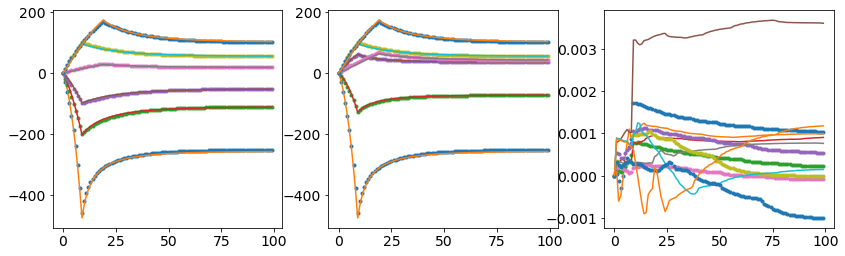

In [80]:
i=4
t = time[0]
fig, ax = plt.subplots(1,3,figsize=(14,4))

sigx_pr = []
sigy_pr = []

sigx_gt = []
sigy_gt = []
sel = [0,6,12,37, 51, 70]
for i in sel:
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_visco(params,     True,  t, lmb_x[i],lmb_y[i])
    sig_gov,lm1_gov,lm2_gov,lm3_gov,lm1e_gov,lm2e_gov,lm3e_gov = biaxial_visco(gov_params, False, t, lmb_x[i],lmb_y[i])

    t = np.linspace(0, t[-1], sig_NN.shape[0])

    ax[0].plot(t,sig_gov[:,0,0],'.')
    ax[1].plot(t,sig_gov[:,1,1],'.')
    ax[2].plot(t,sig_gov[:,2,2],'.')
    ax[0].plot(t,sig_NN[:,0,0],'-')
    ax[1].plot(t,sig_NN[:,1,1],'-')
    ax[2].plot(t,sig_NN[:,2,2],'-')

    sigx_gt.append(sig_gov[:,0,0])
    sigy_gt.append(sig_gov[:,1,1])
    sigx_pr.append(sig_NN[:,0,0])
    sigy_pr.append(sig_NN[:,1,1])

In [92]:
header = ['t']
for txt in ['sigx_gt', 'sigy_gt', 'sigx_pr', 'sigy_pr']:
    for i in range(len(sel)):
        header.append(txt+str(i))
a = np.array([t, *sigx_gt, *sigy_gt, *sigx_pr, *sigy_pr]).T
df = pd.DataFrame(a, columns = header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic.csv', index=False, sep=' ')

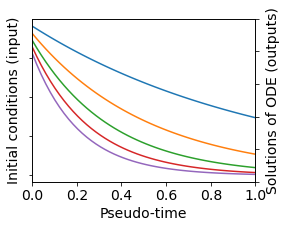

In [133]:
x = np.linspace(1,20)
t = np.linspace(0,1)
fig, ax = plt.subplots(figsize=[4,3])
for i in range(5):
    y = np.exp(-0.05*(i+1)*x)
    ax.plot(t, y)

ax.set(xlabel='Pseudo-time', ylabel='Initial conditions (input)', xlim=[0,1], yticklabels=[])
ax2 = ax.twinx()
ax2.set(ylabel='Solutions of ODE (outputs)', yticklabels=[])
fig.savefig('poster_ode_trj.jpg', bbox_inches='tight')